<a href="https://colab.research.google.com/github/marreapato/Forecasting_Paper_XAI/blob/main/Explanations/EvaluatingExplanaitons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/modelo_forecasting_xai

!ls

/content/gdrive/MyDrive/modelo_forecasting_xai
final_data.csv	model_bilstm


In [3]:
data_dir = "/content/gdrive/MyDrive/modelo_forecasting_xai"


In [4]:
!pip install shap lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=532a889eeeea5f48befa81530509d40f7b5e7e52c13d50546320fa24a73899dd
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [5]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, GRU, Reshape# captum (biblioteca de interpretação pytorch)
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import shap
#from tensorflow.compat.v1.keras.backend import get_session

tf.compat.v1.disable_v2_behavior() # caracteristica necessaria para o uso shap

# Download data for the stock (I'm using the Bovespa index as an example)
data = yf.download('^BVSP', '2007-01-01', '2023-10-17')
data




/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
Instructions for updating:
non-resource variables are not supported in the long term
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-01-02,44476.0,45388.0,44476.0,45383.0,45383.0,75560200
2007-01-03,45379.0,45379.0,44284.0,44445.0,44445.0,122372800
2007-01-04,44442.0,44442.0,43623.0,44020.0,44020.0,86577000
2007-01-05,44019.0,44081.0,42160.0,42245.0,42245.0,164055000
2007-01-08,42249.0,42926.0,42144.0,42830.0,42830.0,114007100
...,...,...,...,...,...,...
2023-10-09,114169.0,115219.0,113448.0,115156.0,115156.0,9474400
2023-10-10,115158.0,116900.0,115158.0,116737.0,116737.0,11621500
2023-10-11,116737.0,117099.0,116231.0,117051.0,117051.0,9949800


In [6]:
# Download historical data for the BRL to USD exchange rate
exchange_rate_data = yf.download('USDBRL=X', start='2007-01-01', end='2023-10-20')

# Display the first few rows of the downloaded data
exchange_rate_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-01-01,2.1310,2.1325,2.1310,2.1325,2.1325,0
2007-01-02,2.1335,2.1432,2.1295,2.1310,2.1310,0
2007-01-03,2.1310,2.1351,2.1278,2.1345,2.1345,0
2007-01-04,2.1345,2.1430,2.1345,2.1390,2.1390,0
2007-01-05,2.1390,2.1525,2.1345,2.1470,2.1470,0


In [7]:
exchange_rate_data.reset_index(inplace=True)
exchange_rate_data = exchange_rate_data[['Date','Close']]
exchange_rate_data = exchange_rate_data.rename(columns={'Close': 'USD'})
exchange_rate_data.head(10)

,Date,USD
0,2007-01-01,2.1325
1,2007-01-02,2.1310
2,2007-01-03,2.1345
3,2007-01-04,2.1390
4,2007-01-05,2.1470
5,2007-01-08,2.1465
6,2007-01-09,2.1490
7,2007-01-10,2.1496
8,2007-01-11,2.1415
9,2007-01-12,2.1370


In [8]:
sheet_id = "19Qm-gxnILXY8QTBASGfwfxp6NsLMOLuEIVmJbQJF8r4"
sheet_name = "structured_data"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
feriados = pd.read_csv(url)
feriados = feriados.drop("Unnamed: 4", axis = 1)
feriados

,Date,4_observance,4_optional,4_public
0,2007-01-01,0,0,1
1,2007-01-02,0,0,1
2,2007-02-17,0,1,0
3,2007-02-18,0,1,0
4,2007-02-19,0,1,0
...,...,...,...,...
697,2024-12-25,0,1,0
698,2024-12-25,0,0,1
699,2024-12-26,0,0,1
700,2024-12-31,0,1,0


In [9]:
data.reset_index(inplace=True)


In [10]:
feriados['Date']=feriados.Date.astype('datetime64[ns]')

In [11]:
data=data.merge(feriados, on='Date', how='left')

In [12]:
data['4_observance'] = data['4_observance'].fillna(0)
data['4_public'] = data['4_public'].fillna(0)
data['4_optional'] = data['4_optional'].fillna(0)

In [13]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,4_observance,4_optional,4_public
0,2007-01-02,44476.0,45388.0,44476.0,45383.0,45383.0,75560200,0.0,0.0,1.0
1,2007-01-03,45379.0,45379.0,44284.0,44445.0,44445.0,122372800,0.0,0.0,0.0
2,2007-01-04,44442.0,44442.0,43623.0,44020.0,44020.0,86577000,0.0,0.0,0.0
3,2007-01-05,44019.0,44081.0,42160.0,42245.0,42245.0,164055000,0.0,0.0,0.0
4,2007-01-08,42249.0,42926.0,42144.0,42830.0,42830.0,114007100,0.0,0.0,0.0


In [14]:
data=data.merge(exchange_rate_data, on='Date', how='left')

In [15]:
data

,Date,Open,High,Low,Close,Adj Close,Volume,4_observance,4_optional,4_public,USD
0,2007-01-02,44476.0,45388.0,44476.0,45383.0,45383.0,75560200,0.0,0.0,1.0,2.1310
1,2007-01-03,45379.0,45379.0,44284.0,44445.0,44445.0,122372800,0.0,0.0,0.0,2.1345
2,2007-01-04,44442.0,44442.0,43623.0,44020.0,44020.0,86577000,0.0,0.0,0.0,2.1390
3,2007-01-05,44019.0,44081.0,42160.0,42245.0,42245.0,164055000,0.0,0.0,0.0,2.1470
4,2007-01-08,42249.0,42926.0,42144.0,42830.0,42830.0,114007100,0.0,0.0,0.0,2.1465
...,...,...,...,...,...,...,...,...,...,...,...
4152,2023-10-09,114169.0,115219.0,113448.0,115156.0,115156.0,9474400,0.0,0.0,0.0,5.1457
4153,2023-10-10,115158.0,116900.0,115158.0,116737.0,116737.0,11621500,0.0,0.0,0.0,5.1352
4154,2023-10-11,116737.0,117099.0,116231.0,117051.0,117051.0,9949800,0.0,0.0,0.0,5.0510
4155,2023-10-13,117050.0,117070.0,115658.0,115754.0,115754.0,10609300,0.0,0.0,1.0,5.0459


In [16]:
data['variation_low_high'] = ((data['High']-data['Low'])/data['Low'])*100

In [17]:
data = data.drop('Adj Close',axis = 1)
data = data.drop('Open',axis = 1)
data = data.drop('High',axis = 1)
data = data.drop('Low',axis = 1)
data = data.drop('Volume',axis = 1)

In [18]:
sheet_id = "19Qm-gxnILXY8QTBASGfwfxp6NsLMOLuEIVmJbQJF8r4"
sheet_name = "Selic"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
selic = pd.read_csv(url)
selic = selic.drop("fonte", axis = 1)
selic

,Date,selic
0,24/01/2007,1
1,07/03/2007,1
2,18/04/2007,1
3,06/06/2007,1
4,18/07/2007,1
...,...,...
131,21/06/2023,1
132,02/08/2023,1
133,20/09/2023,1
134,01/11/2023,1


In [19]:
selic['Date'] = pd.to_datetime(selic['Date'])
selic['Date'].dt.strftime('%Y-%m-%d')

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.


0      2007-01-24
1      2007-07-03
2      2007-04-18
3      2007-06-06
4      2007-07-18
          ...    
131    2023-06-21
132    2023-02-08
133    2023-09-20
134    2023-01-11
135    2023-12-13
Name: Date, Length: 136, dtype: object

In [20]:
data=data.merge(selic, on='Date', how='left')
data['selic'] = data['selic'].fillna(0)
data.head()#SELIC WAS ADDED HERE

,Date,Close,4_observance,4_optional,4_public,USD,variation_low_high,selic
0,2007-01-02,45383.0,0.0,0.0,1.0,2.1310,2.050544,0.0
1,2007-01-03,44445.0,0.0,0.0,0.0,2.1345,2.472676,0.0
2,2007-01-04,44020.0,0.0,0.0,0.0,2.1390,1.877450,0.0
3,2007-01-05,42245.0,0.0,0.0,0.0,2.1470,4.556452,0.0
4,2007-01-08,42830.0,0.0,0.0,0.0,2.1465,1.855543,0.0


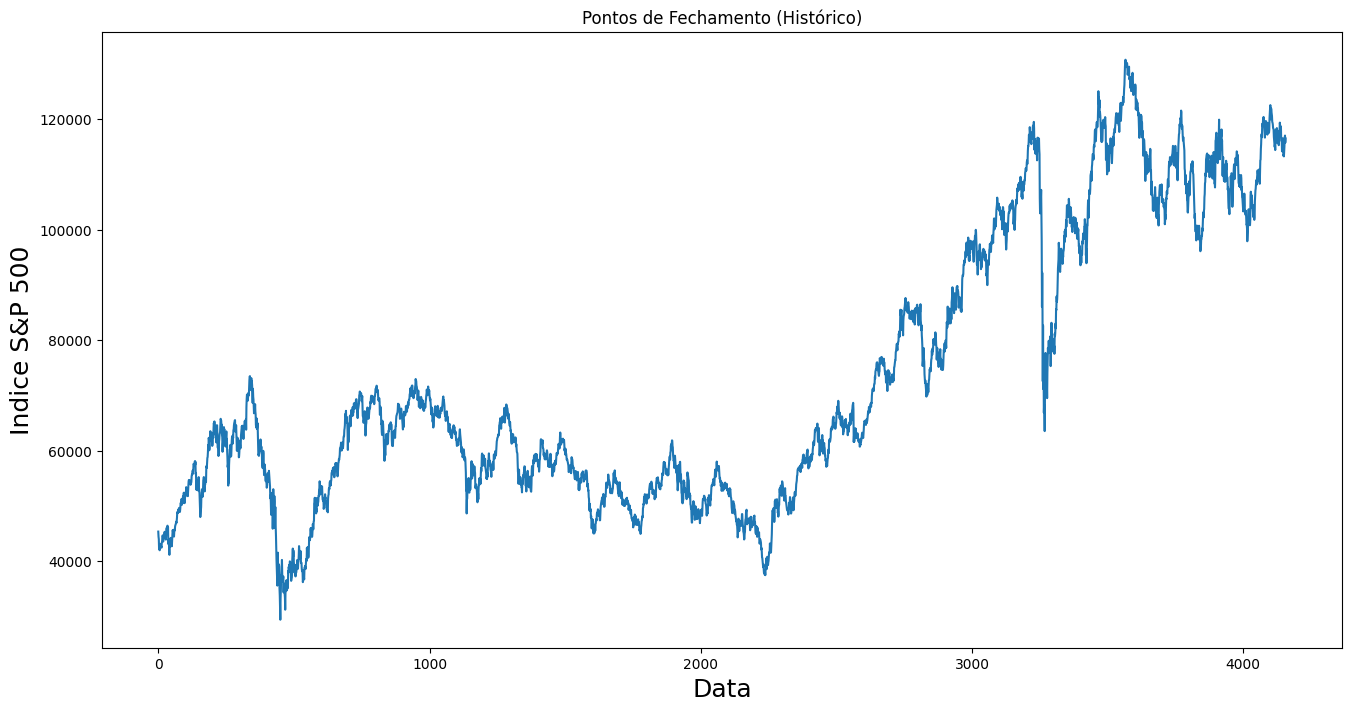

In [21]:
plt.figure(figsize=(16,8))
plt.title("Pontos de Fechamento (Histórico)")
plt.plot(data["Close"])
plt.xlabel("Data",fontsize=18)
plt.ylabel("Indice S&P 500",fontsize=18)
plt.show()

In [22]:
look_back=6

In [23]:
last_rows=(len(data['Close'])-look_back)-int((len(data['Close'].values.reshape(-1, 1)[:])-look_back)*0.8)
last_rows

831

In [24]:
size_of_slice=round((len(data['Close'].values.reshape(-1, 1)[:]))*0.8)
size_of_slice=size_of_slice+(len(data)-(size_of_slice+last_rows))
size_of_slice



3326

In [25]:
data['Close']

0        45383.0
1        44445.0
2        44020.0
3        42245.0
4        42830.0
          ...   
4152    115156.0
4153    116737.0
4154    117051.0
4155    115754.0
4156    116534.0
Name: Close, Length: 4157, dtype: float64

Lagged Data for XAI Comparison

In [26]:
# Normalize the data
#scaler = MinMaxScaler()
#data['Close'] = scaler.fit_transform(data['Close'].values.reshape(-1, 1))#use fit only in training that is wrong


def create_lagged_dataframe(data, lags, include_lag0=False,column_name='Close'):
    lagged_data = data.copy()

    if include_lag0:
        lagged_data['lag0'] = lagged_data[column_name]

    for lag in range(1, lags + 1):
        lagged_data[f'lag{lag}{column_name}'] = lagged_data[column_name].shift(lag)

    return lagged_data
# Split the data into train and test sets


# Create lag features for the entire dataset
include_lag0 = False  # You can set this to True if you want to include lag0

lagged_datansc = create_lagged_dataframe(data, look_back, include_lag0)


In [27]:
lagged_datansc = create_lagged_dataframe(lagged_datansc, look_back, include_lag0,column_name = 'variation_low_high')
lagged_datansc = create_lagged_dataframe(lagged_datansc, look_back, include_lag0,column_name = 'USD')

In [28]:
lagged_datansc

,Date,Close,4_observance,4_optional,4_public,USD,variation_low_high,selic,lag1Close,lag2Close,...,lag3variation_low_high,lag4variation_low_high,lag5variation_low_high,lag6variation_low_high,lag1USD,lag2USD,lag3USD,lag4USD,lag5USD,lag6USD
0,2007-01-02,45383.0,0.0,0.0,1.0,2.1310,2.050544,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2007-01-03,44445.0,0.0,0.0,0.0,2.1345,2.472676,0.0,45383.0,NaN,...,NaN,NaN,NaN,NaN,2.1310,NaN,NaN,NaN,NaN,NaN
2,2007-01-04,44020.0,0.0,0.0,0.0,2.1390,1.877450,0.0,44445.0,45383.0,...,NaN,NaN,NaN,NaN,2.1345,2.1310,NaN,NaN,NaN,NaN
3,2007-01-05,42245.0,0.0,0.0,0.0,2.1470,4.556452,0.0,44020.0,44445.0,...,2.050544,NaN,NaN,NaN,2.1390,2.1345,2.1310,NaN,NaN,NaN
4,2007-01-08,42830.0,0.0,0.0,0.0,2.1465,1.855543,0.0,42245.0,44020.0,...,2.472676,2.050544,NaN,NaN,2.1470,2.1390,2.1345,2.1310,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4152,2023-10-09,115156.0,0.0,0.0,0.0,5.1457,1.561068,0.0,114170.0,113284.0,...,0.919176,1.683591,1.665200,0.999637,5.1650,5.1546,5.1663,5.0615,5.0428,5.0328
4153,2023-10-10,116737.0,0.0,0.0,0.0,5.1352,1.512704,0.0,115156.0,114170.0,...,1.467548,0.919176,1.683591,1.665200,5.1457,5.1650,5.1546,5.1663,5.0615,5.0428
4154,2023-10-11,117051.0,0.0,0.0,0.0,5.0510,0.746789,0.0,116737.0,115156.0,...,2.591421,1.467548,0.919176,1.683591,5.1352,5.1457,5.1650,5.1546,5.1663,5.0615
4155,2023-10-13,115754.0,0.0,0.0,1.0,5.0459,1.220841,0.0,117051.0,116737.0,...,1.561068,2.591421,1.467548,0.919176,5.0510,5.1352,5.1457,5.1650,5.1546,5.1663


In [29]:
lagged_datansc = lagged_datansc.dropna()  # Drop rows with NaN values

train_sizensc = int(len(lagged_datansc) * 0.8)
test_sizensc = len(lagged_datansc) - train_sizensc
trainnsc, testnsc = lagged_datansc[0:train_sizensc], lagged_datansc[train_sizensc:len(data)]

In [30]:
lagged_datansc.head(-1)

,Date,Close,4_observance,4_optional,4_public,USD,variation_low_high,selic,lag1Close,lag2Close,...,lag3variation_low_high,lag4variation_low_high,lag5variation_low_high,lag6variation_low_high,lag1USD,lag2USD,lag3USD,lag4USD,lag5USD,lag6USD
6,2007-01-10,42336.0,0.0,0.0,0.0,2.1496,2.592934,0.0,42007.0,42830.0,...,4.556452,1.877450,2.472676,2.050544,2.1490,2.1465,2.1470,2.1390,2.1345,2.1310
7,2007-01-11,42670.0,0.0,0.0,0.0,2.1415,2.832618,0.0,42336.0,42007.0,...,1.855543,4.556452,1.877450,2.472676,2.1496,2.1490,2.1465,2.1470,2.1390,2.1345
8,2007-01-12,43095.0,0.0,0.0,0.0,2.1370,1.556695,0.0,42670.0,42336.0,...,3.771900,1.855543,4.556452,1.877450,2.1415,2.1496,2.1490,2.1465,2.1470,2.1390
9,2007-01-15,42919.0,0.0,0.0,0.0,2.1368,1.394752,0.0,43095.0,42670.0,...,2.592934,3.771900,1.855543,4.556452,2.1370,2.1415,2.1496,2.1490,2.1465,2.1470
10,2007-01-16,42624.0,0.0,0.0,0.0,2.1396,1.181186,0.0,42919.0,43095.0,...,2.832618,2.592934,3.771900,1.855543,2.1368,2.1370,2.1415,2.1496,2.1490,2.1465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4151,2023-10-06,114170.0,0.0,0.0,0.0,5.1650,2.591421,0.0,113284.0,113607.0,...,1.683591,1.665200,0.999637,0.995549,5.1546,5.1663,5.0615,5.0428,5.0328,5.0422
4152,2023-10-09,115156.0,0.0,0.0,0.0,5.1457,1.561068,0.0,114170.0,113284.0,...,0.919176,1.683591,1.665200,0.999637,5.1650,5.1546,5.1663,5.0615,5.0428,5.0328
4153,2023-10-10,116737.0,0.0,0.0,0.0,5.1352,1.512704,0.0,115156.0,114170.0,...,1.467548,0.919176,1.683591,1.665200,5.1457,5.1650,5.1546,5.1663,5.0615,5.0428
4154,2023-10-11,117051.0,0.0,0.0,0.0,5.0510,0.746789,0.0,116737.0,115156.0,...,2.591421,1.467548,0.919176,1.683591,5.1352,5.1457,5.1650,5.1546,5.1663,5.0615


In [31]:
trainXnsc= trainnsc.drop(columns=['Close','Date']).values
testXnsc = testnsc.drop(columns=['Close','Date','USD','variation_low_high']).values
trainYnsc= trainnsc['Close'].values
testYnsc= testnsc['Close'].values

print("TrainX shape:", trainXnsc.shape)
print("TrainY shape:", trainYnsc.shape)
print("TestX shape:", testXnsc.shape)
print("TestY shape:", testYnsc.shape)

TrainX shape: (3226, 24)
TrainY shape: (3226,)
TestX shape: (807, 22)
TestY shape: (807,)


After

In [32]:
# Normalize the data
closescaler = MinMaxScaler()

data_train=pd.DataFrame(closescaler.fit_transform(data['Close'].values[0:size_of_slice].reshape(-1, 1)),
                        columns=['Close'],index=data['Close'].index[0:size_of_slice])#use fit only in training that is wrong
data_test=pd.DataFrame(closescaler.transform(data['Close'].values[size_of_slice:size_of_slice+last_rows].reshape(-1, 1)),
                       columns=['Close'],index=data['Close'].index[size_of_slice:size_of_slice+last_rows])#use fit only in training that is wrong

In [33]:
train_datanscal = data.iloc[0:size_of_slice]
test_datanscal = data.iloc[size_of_slice:size_of_slice+last_rows]

In [34]:
data.columns

Index(['Date', 'Close', '4_observance', '4_optional', '4_public', 'USD',
       'variation_low_high', 'selic'],
      dtype='object')

In [35]:
# Normalize the data
scaler = MinMaxScaler()

train_datanscal[['variation_low_high', 'Close',
       '4_observance', '4_optional', '4_public','selic','USD']] = scaler.fit_transform(train_datanscal[['variation_low_high', 'Close',
       '4_observance', '4_optional', '4_public','selic','USD']])
train_datanscal.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Date,Close,4_observance,4_optional,4_public,USD,variation_low_high,selic
0,2007-01-02,0.177017,0.0,0.0,1.0,0.137225,0.073612,0.0
1,2007-01-03,0.166606,0.0,0.0,0.0,0.138029,0.091220,0.0
2,2007-01-04,0.161888,0.0,0.0,0.0,0.139063,0.066392,0.0
3,2007-01-05,0.142186,0.0,0.0,0.0,0.140901,0.178138,0.0
4,2007-01-08,0.148680,0.0,0.0,0.0,0.140786,0.065478,0.0


In [36]:
test_datanscal[['variation_low_high','Close',
       '4_observance', '4_optional', '4_public','selic','USD']] = scaler.transform(test_datanscal[['variation_low_high', 'Close',
       '4_observance', '4_optional', '4_public','selic','USD']])
test_datanscal.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Date,Close,4_observance,4_optional,4_public,USD,variation_low_high,selic
3326,2020-06-16,0.711443,0.0,0.0,0.0,0.831554,0.115807,0.0
3327,2020-06-17,0.733819,0.0,0.0,0.0,0.852321,0.125438,1.0
3328,2020-06-18,0.740235,0.0,0.0,0.0,0.848715,0.094322,0.0
3329,2020-06-19,0.745197,0.0,0.0,0.0,0.883015,0.060562,0.0
3330,2020-06-22,0.731477,0.0,0.0,0.0,0.867576,0.076059,0.0


In [37]:
order_standardize = ['variation_low_high','Close',
       '4_observance', '4_optional', '4_public','selic','USD']

In [38]:
data_train=train_datanscal.append(test_datanscal)

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [39]:
data_train.shape

(4157, 8)

In [40]:
len(data_train)==len(data)

True

In [41]:
data_train.shape

(4157, 8)

In [42]:
# Normalize the data
#scaler = MinMaxScaler()
#data['Close'] = scaler.fit_transform(data['Close'].values.reshape(-1, 1))#use fit only in training that is wrong


def create_lagged_dataframe(data, lags, include_lag0=False,column_name='Close'):
    lagged_data = data.copy()

    if include_lag0:
        lagged_data['lag0'] = lagged_data[column_name]

    for lag in range(1, lags + 1):
        lagged_data[f'lag{lag}{column_name}'] = lagged_data[column_name].shift(lag)

    return lagged_data
# Split the data into train and test sets


# Create lag features for the entire dataset
include_lag0 = False  # You can set this to True if you want to include lag0

lagged_data = create_lagged_dataframe(data_train, look_back, include_lag0)


In [43]:
lagged_data = create_lagged_dataframe(lagged_data, look_back, include_lag0,column_name = 'variation_low_high')
lagged_data = create_lagged_dataframe(lagged_data, look_back, include_lag0,column_name = 'USD')

In [44]:
lagged_data

,Date,Close,4_observance,4_optional,4_public,USD,variation_low_high,selic,lag1Close,lag2Close,...,lag3variation_low_high,lag4variation_low_high,lag5variation_low_high,lag6variation_low_high,lag1USD,lag2USD,lag3USD,lag4USD,lag5USD,lag6USD
0,2007-01-02,0.177017,0.0,0.0,1.0,0.137225,0.073612,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2007-01-03,0.166606,0.0,0.0,0.0,0.138029,0.091220,0.0,0.177017,NaN,...,NaN,NaN,NaN,NaN,0.137225,NaN,NaN,NaN,NaN,NaN
2,2007-01-04,0.161888,0.0,0.0,0.0,0.139063,0.066392,0.0,0.166606,0.177017,...,NaN,NaN,NaN,NaN,0.138029,0.137225,NaN,NaN,NaN,NaN
3,2007-01-05,0.142186,0.0,0.0,0.0,0.140901,0.178138,0.0,0.161888,0.166606,...,0.073612,NaN,NaN,NaN,0.139063,0.138029,0.137225,NaN,NaN,NaN
4,2007-01-08,0.148680,0.0,0.0,0.0,0.140786,0.065478,0.0,0.142186,0.161888,...,0.091220,0.073612,NaN,NaN,0.140901,0.139063,0.138029,0.137225,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4152,2023-10-09,0.951472,0.0,0.0,0.0,0.829830,0.053195,0.0,0.940528,0.930694,...,0.026420,0.058305,0.057538,0.029776,0.834264,0.831874,0.834562,0.810485,0.806189,0.803892
4153,2023-10-10,0.969021,0.0,0.0,0.0,0.827417,0.051177,0.0,0.951472,0.940528,...,0.049294,0.026420,0.058305,0.057538,0.829830,0.834264,0.831874,0.834562,0.810485,0.806189
4154,2023-10-11,0.972506,0.0,0.0,0.0,0.808073,0.019230,0.0,0.969021,0.951472,...,0.096173,0.049294,0.026420,0.058305,0.827417,0.829830,0.834264,0.831874,0.834562,0.810485
4155,2023-10-13,0.958110,0.0,0.0,1.0,0.806901,0.039003,0.0,0.972506,0.969021,...,0.053195,0.096173,0.049294,0.026420,0.808073,0.827417,0.829830,0.834264,0.831874,0.834562


In [45]:
lagged_data= lagged_data.drop(columns=['USD','variation_low_high'])

In [46]:
lagged_data = lagged_data.dropna()  # Drop rows with NaN values

train_size = int(len(lagged_data) * 0.8)
test_size = len(lagged_data) - train_size
train, test = lagged_data[0:train_size], lagged_data[train_size:len(data)]

In [47]:
lagged_data.head(-1)

,Date,Close,4_observance,4_optional,4_public,selic,lag1Close,lag2Close,lag3Close,lag4Close,...,lag3variation_low_high,lag4variation_low_high,lag5variation_low_high,lag6variation_low_high,lag1USD,lag2USD,lag3USD,lag4USD,lag5USD,lag6USD
6,2007-01-10,0.143196,0.0,0.0,0.0,0.0,0.139545,0.148680,0.142186,0.161888,...,0.178138,0.066392,0.091220,0.073612,0.141361,0.140786,0.140901,0.139063,0.138029,0.137225
7,2007-01-11,0.146904,0.0,0.0,0.0,0.0,0.143196,0.139545,0.148680,0.142186,...,0.065478,0.178138,0.066392,0.091220,0.141498,0.141361,0.140786,0.140901,0.139063,0.138029
8,2007-01-12,0.151621,0.0,0.0,0.0,0.0,0.146904,0.143196,0.139545,0.148680,...,0.145413,0.065478,0.178138,0.066392,0.139637,0.141498,0.141361,0.140786,0.140901,0.139063
9,2007-01-15,0.149668,0.0,0.0,0.0,0.0,0.151621,0.146904,0.143196,0.139545,...,0.096236,0.145413,0.065478,0.178138,0.138604,0.139637,0.141498,0.141361,0.140786,0.140901
10,2007-01-16,0.146393,0.0,0.0,0.0,0.0,0.149668,0.151621,0.146904,0.143196,...,0.106234,0.096236,0.145413,0.065478,0.138558,0.138604,0.139637,0.141498,0.141361,0.140786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4151,2023-10-06,0.940528,0.0,0.0,0.0,0.0,0.930694,0.934279,0.932192,0.950374,...,0.058305,0.057538,0.029776,0.029606,0.831874,0.834562,0.810485,0.806189,0.803892,0.806051
4152,2023-10-09,0.951472,0.0,0.0,0.0,0.0,0.940528,0.930694,0.934279,0.932192,...,0.026420,0.058305,0.057538,0.029776,0.834264,0.831874,0.834562,0.810485,0.806189,0.803892
4153,2023-10-10,0.969021,0.0,0.0,0.0,0.0,0.951472,0.940528,0.930694,0.934279,...,0.049294,0.026420,0.058305,0.057538,0.829830,0.834264,0.831874,0.834562,0.810485,0.806189
4154,2023-10-11,0.972506,0.0,0.0,0.0,0.0,0.969021,0.951472,0.940528,0.930694,...,0.096173,0.049294,0.026420,0.058305,0.827417,0.829830,0.834264,0.831874,0.834562,0.810485


In [48]:
trainX= train.drop(columns=['Close','Date']).values
testX = test.drop(columns=['Close','Date']).values
trainY= train['Close'].values
testY= test['Close'].values

print("TrainX shape:", trainX.shape)
print("TrainY shape:", trainY.shape)
print("TestX shape:", testX.shape)
print("TestY shape:", testY.shape)

TrainX shape: (3237, 22)
TrainY shape: (3237,)
TestX shape: (810, 22)
TestY shape: (810,)


In [49]:
trainX

array([[0.        , 0.        , 0.        , ..., 0.13906309, 0.13802927,
        0.13722518],
       [0.        , 0.        , 0.        , ..., 0.14090106, 0.13906309,
        0.13802927],
       [0.        , 0.        , 0.        , ..., 0.1407862 , 0.14090106,
        0.13906309],
       ...,
       [0.        , 0.        , 0.        , ..., 0.86789803, 0.87881082,
        0.86900076],
       [0.        , 0.        , 0.        , ..., 0.877754  , 0.86789803,
        0.87881082],
       [0.        , 0.        , 0.        , ..., 0.88315294, 0.877754  ,
        0.86789803]])

In [50]:
trainX.shape

(3237, 22)

In [51]:
trainX = np.array(trainX)
testX = np.array(testX)

In [52]:
np.reshape(trainX, (1,-1)).shape

(1, 71214)

In [53]:
bilstm_model = tf.keras.models.load_model('/content/gdrive/MyDrive/modelo_forecasting_xai/model_bilstm')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [54]:
bilstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           multiple                  0         
                                                                 
 bidirectional (Bidirection  multiple                  154624    
 al)                                                             
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  257       
                                                                 
Total params: 154881 (605.00 KB)
Trainable params: 154881 (605.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [55]:
bilstm_model.predict(testX)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


array([[0.7864285 ],
       [0.7996874 ],
       [0.7991617 ],
       [0.80970556],
       [0.823003  ],
       [0.83120984],
       [0.8372611 ],
       [0.8281838 ],
       [0.82292587],
       [0.8284995 ],
       [0.8361189 ],
       [0.8411615 ],
       [0.84441334],
       [0.8294104 ],
       [0.8251537 ],
       [0.8092959 ],
       [0.8130977 ],
       [0.82211745],
       [0.8156349 ],
       [0.8212837 ],
       [0.81619257],
       [0.81422627],
       [0.80562824],
       [0.80704015],
       [0.79827774],
       [0.80384135],
       [0.80026   ],
       [0.80414134],
       [0.80777925],
       [0.81158555],
       [0.8190621 ],
       [0.8072763 ],
       [0.80465364],
       [0.8091957 ],
       [0.8037399 ],
       [0.80556023],
       [0.81223863],
       [0.80383253],
       [0.8215326 ],
       [0.7978225 ],
       [0.8066755 ],
       [0.79238224],
       [0.78273576],
       [0.7882928 ],
       [0.79924554],
       [0.79399735],
       [0.7957038 ],
       [0.784

# Shap

In [56]:
sample_train = trainX.copy()
gru_explainer = shap.DeepExplainer(bilstm_model, data=sample_train)  # Substitua 10 pelo número desejado de exemplos para a baseline

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [57]:
# Calcular os valores SHAP
sample = testX.copy()


In [58]:
#sample = sample.reshape(831,11)

In [59]:
shap_values = gru_explainer.shap_values(sample)



In [60]:
print(shap_values[0].shape)
shap_values[0]

(810, 22)


array([[ 8.88173795e-05,  1.23069563e-04, -2.41846516e-04, ...,
         4.44100239e-02,  1.54522924e-02,  1.25074802e-02],
       [ 7.52905815e-05,  1.24456513e-04, -2.42343975e-04, ...,
         4.40934369e-02,  1.50512158e-02,  1.27514427e-02],
       [ 7.82651022e-05,  1.25506832e-04, -2.47746952e-04, ...,
         4.37698210e-02,  1.46635282e-02,  1.29893329e-02],
       ...,
       [ 5.92050658e-05,  1.57454748e-04, -3.18039937e-04, ...,
         3.74860000e-02,  1.20830431e-02,  1.36431766e-02],
       [ 8.36655991e-05,  1.23799862e-04,  1.33151182e-02, ...,
         3.95271644e-02,  1.28060468e-02,  1.39185968e-02],
       [ 5.85492207e-05,  1.60616014e-04, -3.33992040e-04, ...,
         3.71276440e-02,  1.24363146e-02,  1.42219194e-02]])

In [61]:
sample

array([[0.        , 0.        , 0.        , ..., 0.87506598, 0.88315294,
        0.877754  ],
       [0.        , 0.        , 0.        , ..., 0.87396325, 0.87506598,
        0.88315294],
       [0.        , 0.        , 0.        , ..., 0.87145905, 0.87396325,
        0.87506598],
       ...,
       [0.        , 0.        , 0.        , ..., 0.83187446, 0.83456237,
        0.81048542],
       [0.        , 0.        , 1.        , ..., 0.83426374, 0.83187446,
        0.83456237],
       [0.        , 0.        , 0.        , ..., 0.82982971, 0.83426374,
        0.83187446]])

In [62]:
columnnames = lagged_data.columns[1:].values

In [63]:
np.delete(lagged_data.columns[1:].values, 0)


array(['4_observance', '4_optional', '4_public', 'selic', 'lag1Close',
       'lag2Close', 'lag3Close', 'lag4Close', 'lag5Close', 'lag6Close',
       'lag1variation_low_high', 'lag2variation_low_high',
       'lag3variation_low_high', 'lag4variation_low_high',
       'lag5variation_low_high', 'lag6variation_low_high', 'lag1USD',
       'lag2USD', 'lag3USD', 'lag4USD', 'lag5USD', 'lag6USD'],
      dtype=object)

In [64]:
columnnames = np.delete(columnnames, 0)
columnnames

array(['4_observance', '4_optional', '4_public', 'selic', 'lag1Close',
       'lag2Close', 'lag3Close', 'lag4Close', 'lag5Close', 'lag6Close',
       'lag1variation_low_high', 'lag2variation_low_high',
       'lag3variation_low_high', 'lag4variation_low_high',
       'lag5variation_low_high', 'lag6variation_low_high', 'lag1USD',
       'lag2USD', 'lag3USD', 'lag4USD', 'lag5USD', 'lag6USD'],
      dtype=object)

In [65]:
shap_values[0]

array([[ 8.88173795e-05,  1.23069563e-04, -2.41846516e-04, ...,
         4.44100239e-02,  1.54522924e-02,  1.25074802e-02],
       [ 7.52905815e-05,  1.24456513e-04, -2.42343975e-04, ...,
         4.40934369e-02,  1.50512158e-02,  1.27514427e-02],
       [ 7.82651022e-05,  1.25506832e-04, -2.47746952e-04, ...,
         4.37698210e-02,  1.46635282e-02,  1.29893329e-02],
       ...,
       [ 5.92050658e-05,  1.57454748e-04, -3.18039937e-04, ...,
         3.74860000e-02,  1.20830431e-02,  1.36431766e-02],
       [ 8.36655991e-05,  1.23799862e-04,  1.33151182e-02, ...,
         3.95271644e-02,  1.28060468e-02,  1.39185968e-02],
       [ 5.85492207e-05,  1.60616014e-04, -3.33992040e-04, ...,
         3.71276440e-02,  1.24363146e-02,  1.42219194e-02]])

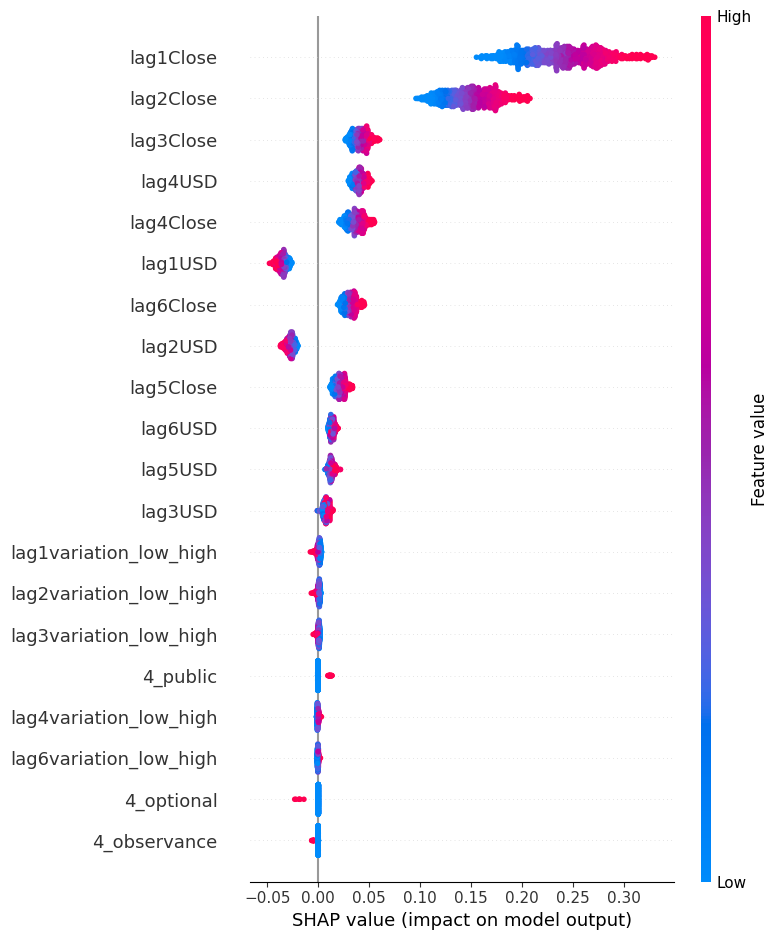

In [66]:
# Visualizar as contribuições
shap.summary_plot(
  shap_values[0],
  sample,
  feature_names=columnnames
)

# Validação Lime

In [67]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
# Set a seed for reproducibility
np.random.seed(42)
# Criando um explainer do Lime
explainer = LimeTabularExplainer(trainX,
                                 mode="regression",
                                 feature_names=columnnames,
                                 class_names=['ibv'],
                                 categorical_features=[[0,1,2,5]],
                                 discretize_continuous=True)

809


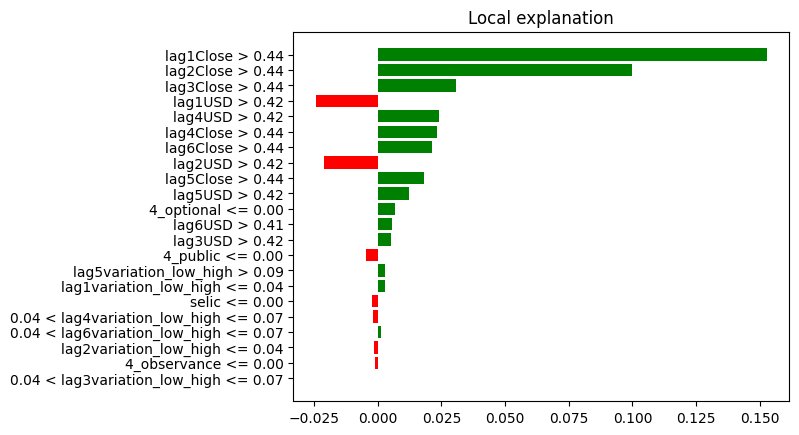

In [68]:
#values 1
sample_idx = 809#np.random.choice(range(len(testX)), size=(1,))[0]#830
print(sample_idx)
np.random.seed(42)
X_sample = testX[sample_idx]#testXnsc[sample_idx]

# Explicação do modelo usando o explainer do Lime
explanation1 = explainer.explain_instance(X_sample,
                                         bilstm_model.predict,
                                         num_features=(22))

# Visualizando a explicação
fig = explanation1.as_pyplot_figure()
plt.show()

In [72]:
scaler.inverse_transform(np.array([0.09,0.44,0,0,0,0,0.42]).reshape(1,-1))[0][0]

2.4434334661787256

In [70]:
order_standardize

['variation_low_high',
 'Close',
 '4_observance',
 '4_optional',
 '4_public',
 'selic',
 'USD']

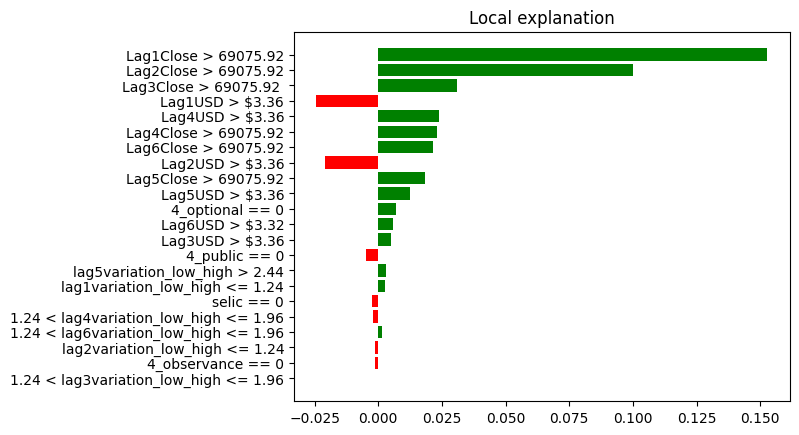

In [69]:
# Visualizando a explicação
fig = explanation1.as_pyplot_figure()
lime_ax = fig.gca()
# Change the text labels on the x-axis tick
#lime_ax.set_xticklabels(['Label1', 'Label2', 'Label3'])
# Change the text labels on the y-axis ticks
lime_ax.set_yticklabels([  '1.24 < lag3variation_low_high <= 1.96', '4_observance == 0','lag2variation_low_high <= 1.24','1.24 < lag6variation_low_high <= 1.96','1.24 < lag4variation_low_high <= 1.96', 'selic == 0', 'lag1variation_low_high <= 1.24','lag5variation_low_high > 2.44','4_public == 0','Lag3USD > $3.36', 'Lag6USD > $3.32','4_optional == 0','Lag5USD > $3.36', 'Lag5Close > 69075.92', 'Lag2USD > $3.36','Lag6Close > 69075.92', 'Lag4Close > 69075.92', 'Lag4USD > $3.36','Lag1USD > $3.36', 'Lag3Close > 69075.92 ', 'Lag2Close > 69075.92','Lag1Close > 69075.92'])

# Show the modified Lime plot
plt.show()


809


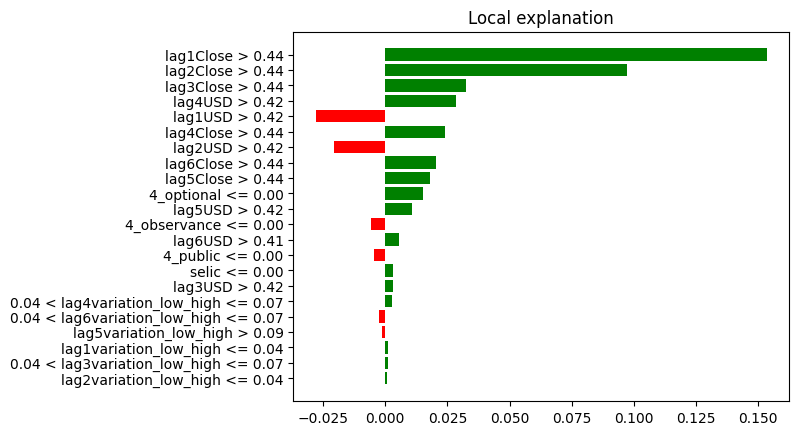

In [70]:
#values 2
np.random.seed(4)
sample_idx = 809#np.random.choice(range(len(testX)), size=(1,))[0]#830
print(sample_idx)
X_sample = testX[sample_idx]#testXnsc[sample_idx]

# Explicação do modelo usando o explainer do Lime
explanation2 = explainer.explain_instance(X_sample,
                                         bilstm_model.predict,
                                         num_features=(22))

# Visualizando a explicação
fig = explanation2.as_pyplot_figure()
plt.show()

In [76]:
scaler.inverse_transform(np.array([0.07,0.44,0,0,0,0,0.42]).reshape(1,-1))[0][0]

1.963954546066836

In [72]:
order_standardize

['variation_low_high',
 'Close',
 '4_observance',
 '4_optional',
 '4_public',
 'selic',
 'USD']

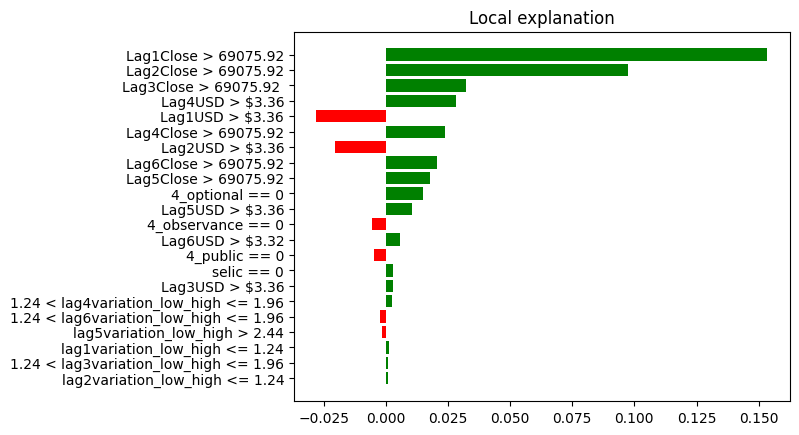

In [74]:
# Visualizando a explicação
fig = explanation2.as_pyplot_figure()
lime_ax = fig.gca()
# Change the text labels on the x-axis tick
#lime_ax.set_xticklabels(['Label1', 'Label2', 'Label3'])
# Change the text labels on the y-axis ticks
lime_ax.set_yticklabels(['lag2variation_low_high <= 1.24','1.24 < lag3variation_low_high <= 1.96', 'lag1variation_low_high <= 1.24',  'lag5variation_low_high > 2.44','1.24 < lag6variation_low_high <= 1.96', '1.24 < lag4variation_low_high <= 1.96','Lag3USD > $3.36', 'selic == 0', '4_public == 0', 'Lag6USD > $3.32', '4_observance == 0','Lag5USD > $3.36','4_optional == 0', 'Lag5Close > 69075.92','Lag6Close > 69075.92', 'Lag2USD > $3.36', 'Lag4Close > 69075.92', 'Lag1USD > $3.36','Lag4USD > $3.36', 'Lag3Close > 69075.92 ', 'Lag2Close > 69075.92','Lag1Close > 69075.92'])

# Show the modified Lime plot
plt.show()


809


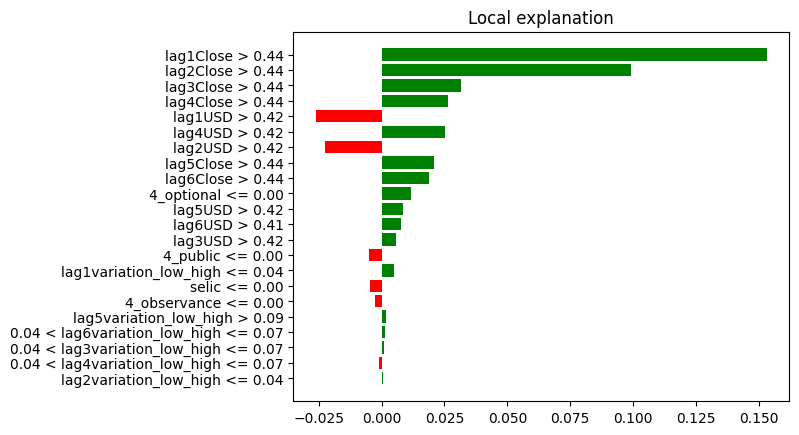

In [77]:
#values 3
np.random.seed(3)
sample_idx = 809#np.random.choice(range(len(testX)), size=(1,))[0]#830
print(sample_idx)
X_sample = testX[sample_idx]#testXnsc[sample_idx]

# Explicação do modelo usando o explainer do Lime
explanation3 = explainer.explain_instance(X_sample,
                                         bilstm_model.predict,
                                         num_features=(22))

# Visualizando a explicação
fig = explanation3.as_pyplot_figure()
plt.show()

In [78]:
scaler.inverse_transform(np.array([0.07,0.44,0,0,0,0,0.42]).reshape(1,-1))[0][0]

1.963954546066836

In [79]:
order_standardize

['variation_low_high',
 'Close',
 '4_observance',
 '4_optional',
 '4_public',
 'selic',
 'USD']

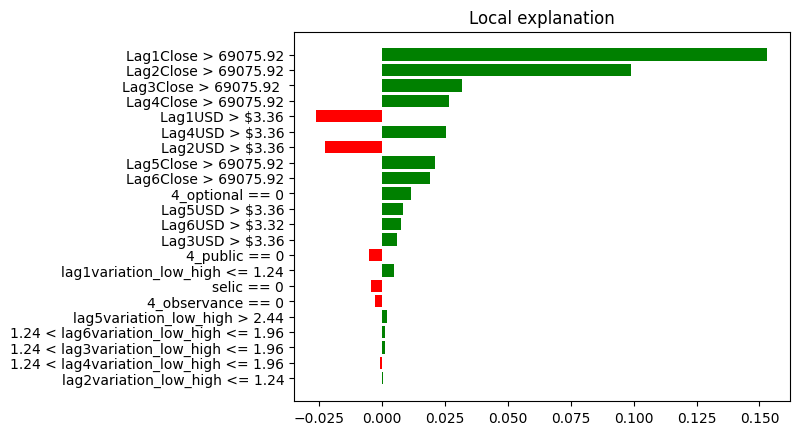

In [80]:
# Visualizando a explicação
fig = explanation3.as_pyplot_figure()
lime_ax = fig.gca()
# Change the text labels on the x-axis tick
#lime_ax.set_xticklabels(['Label1', 'Label2', 'Label3'])
# Change the text labels on the y-axis ticks
lime_ax.set_yticklabels(['lag2variation_low_high <= 1.24', '1.24 < lag4variation_low_high <= 1.96','1.24 < lag3variation_low_high <= 1.96','1.24 < lag6variation_low_high <= 1.96',  'lag5variation_low_high > 2.44', '4_observance == 0', 'selic == 0', 'lag1variation_low_high <= 1.24', '4_public == 0','Lag3USD > $3.36', 'Lag6USD > $3.32','Lag5USD > $3.36','4_optional == 0','Lag6Close > 69075.92', 'Lag5Close > 69075.92', 'Lag2USD > $3.36','Lag4USD > $3.36', 'Lag1USD > $3.36', 'Lag4Close > 69075.92', 'Lag3Close > 69075.92 ', 'Lag2Close > 69075.92','Lag1Close > 69075.92'])

# Show the modified Lime plot
plt.show()


In [81]:
list_of_listsexplanation1 = [list(elem) for elem in list(explanation1.local_exp.values())[0]]
for x in list_of_listsexplanation1:
    del x[0]
list_of_listsexplanation1

[[-0.15277602073068514],
 [-0.09987154020734759],
 [-0.030835231120199938],
 [0.02430912149187068],
 [-0.023929275837027853],
 [-0.023089935400169456],
 [-0.021401399381805866],
 [0.02093383232748753],
 [-0.01821952672597785],
 [-0.01233011847661527],
 [-0.006855151309385158],
 [-0.005663507514832078],
 [-0.0051612913678150685],
 [0.004638004722078829],
 [-0.002982175524003491],
 [-0.0027057401360268845],
 [0.002353891085791294],
 [0.0020249961843092613],
 [-0.0013944498198061577],
 [0.001383777465739479],
 [0.0012168714892670427],
 [5.305521152352759e-06]]

In [82]:
explanations_first = np.array(list_of_listsexplanation1).reshape(-1)

In [83]:
list_of_listsexplanation2 = [list(elem) for elem in list(explanation2.local_exp.values())[0]]
for x in list_of_listsexplanation2:
    del x[0]



explanations_2 = np.array(list_of_listsexplanation2).reshape(-1)


In [84]:
list_of_listsexplanation3 = [list(elem) for elem in list(explanation3.local_exp.values())[0]]
for x in list_of_listsexplanation3:
    del x[0]
explanations_3 = np.array(list_of_listsexplanation3).reshape(-1)

In [85]:
print(explanations_3.shape)
print(explanations_2.shape)

(22,)
(22,)


In [86]:
explanations_full_df = pd.DataFrame({"exp1":explanations_first,"exp2":explanations_2,"exp3":explanations_3})

In [87]:
explanations_full_df.head()

,exp1,exp2,exp3
0,-0.152776,-0.153469,-0.153139
1,-0.099872,-0.097350,-0.099057
2,-0.030835,-0.032406,-0.031679
3,0.024309,-0.028274,-0.026566
4,-0.023929,0.027889,0.026113


#Statistical Tests

In [88]:

from scipy.stats import shapiro

#make this example reproducible
np.random.seed(1)

#perform Shapiro-Wilk test for normality
print(shapiro(explanations_full_df['exp1']),"\n",
shapiro(explanations_full_df['exp2']),"\n",
shapiro(explanations_full_df['exp3']))#no evidence to say that data follows a normal distribution, hence we reject the null hypothesis going for non parametrical test


ShapiroResult(statistic=0.6665559411048889, pvalue=7.564139650639845e-06) 
 ShapiroResult(statistic=0.6923482418060303, pvalue=1.5665566024836153e-05) 
 ShapiroResult(statistic=0.6873027086257935, pvalue=1.3550332369050011e-05)


In [89]:
from scipy.stats import kruskal

kruskal(explanations_full_df['exp1'], explanations_full_df['exp2'], explanations_full_df['exp3'])#we don't have evidence to say that at least one tratment is different


KruskalResult(statistic=0.00912791414828007, pvalue=0.9954464419516963)

In [90]:
X_sample#id 188 has dummy 1

array([0.        , 0.        , 0.        , 0.        , 0.95810995,
       0.97250619, 0.9690209 , 0.95147237, 0.94052812, 0.93069384,
       0.03900328, 0.01922964, 0.05117747, 0.0531948 , 0.09617285,
       0.04929392, 0.80690139, 0.80807314, 0.82741743, 0.82982971,
       0.83426374, 0.83187446])

In [91]:
columnnames

array(['4_observance', '4_optional', '4_public', 'selic', 'lag1Close',
       'lag2Close', 'lag3Close', 'lag4Close', 'lag5Close', 'lag6Close',
       'lag1variation_low_high', 'lag2variation_low_high',
       'lag3variation_low_high', 'lag4variation_low_high',
       'lag5variation_low_high', 'lag6variation_low_high', 'lag1USD',
       'lag2USD', 'lag3USD', 'lag4USD', 'lag5USD', 'lag6USD'],
      dtype=object)

In [92]:
testXnsc[sample_idx]


IndexError: index 809 is out of bounds for axis 0 with size 807